In [6]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

#os.chdir("C:\\Users\\Taha\\Desktop\\Hate Speach")

In [3]:
#pip install tensorflow


  Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl.metadata (2.5 kB)
Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
anyio                        3.5.0
argon2-cffi                  20.1.0
asgiref                      3.7.2
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
brotlipy                     0.7.0
cachetools                   5.3.3
certifi                      2020.6.20
cffi                         1.15.1
charset-normalizer           2.0.4
click                        8.1.7
cloudpickle                  2.2.1
colorama                     0.4.6
cryptography                 39.0.1
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.1
defusedxml                   0.7.1
Django                       3.0.2
django-crispy-forms          1.8.1
eli5                         0.13.0


In [7]:
main_data=pd.read_csv("train.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


,label
0,29720
1,2242


0s : 1s  ::   13.26 : 1


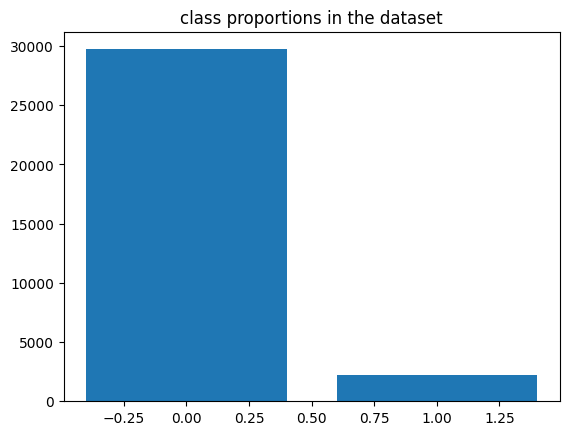

In [8]:
#Check class distribution in dependent variable 
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

#### we see that we have an unbalanced data mojority class to minority class ratio of 13 : 1

,label
0,29720
1,6726


0s : 1s  ::   4.42 : 1


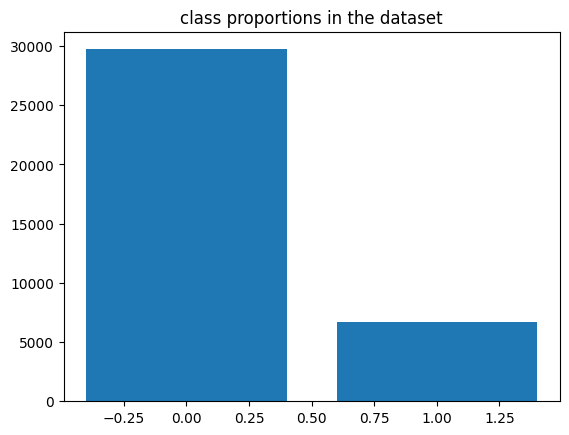

In [9]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [11]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split())) 

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [12]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
0    23720
1     5436
Name: label, dtype: int64
29156
===========Test Data =========
0    6000
1    1290
Name: label, dtype: int64
7290


In [13]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:23324
Class distributionCounter({0: 18975, 1: 4349})
Valid data len:5832
Class distributionCounter({0: 4745, 1: 1087})


In [14]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [15]:
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding 
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:23324
Class distributionCounter({0: 18975, 1: 4349})
Validation data len:5832
Class distributionCounter({0: 4745, 1: 1087})
Test data len:7290
Class distributionCounter({0: 6000, 1: 1290})


In [16]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[ 104    8   52   19  388   12   25  210 8080    5 4817 1248    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
======Validation dataset ====
tf.Tensor(
[11160    59    11   242     7    59    11   240   175    31    12     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
======Test dataset ====
tf.Tensor(
[849 103  27   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [17]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            800016    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [18]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
23/23 [==============================] - 26s 511ms/step - loss: 2.9863 - binary_accuracy: 0.7638 - val_loss: 1.5805 - val_binary_accuracy: 0.8136
Epoch 2/10
23/23 [==============================] - 10s 447ms/step - loss: 1.1507 - binary_accuracy: 0.8135 - val_loss: 0.8012 - val_binary_accuracy: 0.8136
Epoch 3/10
23/23 [==============================] - 10s 440ms/step - loss: 0.7486 - binary_accuracy: 0.8135 - val_loss: 0.6312 - val_binary_accuracy: 0.8136
Epoch 4/10
23/23 [==============================] - 11s 465ms/step - loss: 0.6185 - binary_accuracy: 0.8135 - val_loss: 0.5176 - val_binary_accuracy: 0.8136
Epoch 5/10
23/23 [==============================] - 11s 469ms/step - loss: 0.4949 - binary_accuracy: 0.8681 - val_loss: 0.3688 - val_binary_accuracy: 0.9210
Epoch 6/10
23/23 [==============================] - 10s 441ms/step - loss: 0.4039 - binary_accuracy: 0.9309 - val_loss: 0.3138 - val_binary_accuracy: 0.9487
Epoch 7/10
23/23 [==============================] - 10s 44

In [19]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

183/183 [==============================] - 3s 12ms/step
[[8.3530686e-05]
 [5.0467223e-02]
 [4.1803187e-01]
 [5.8716345e-01]
 [9.9342042e-01]
 [3.1066684e-03]
 [3.8841832e-03]
 [1.9755899e-03]
 [1.7230224e-05]
 [5.3686937e-03]]


In [20]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

228/228 [==============================] - 3s 12ms/step


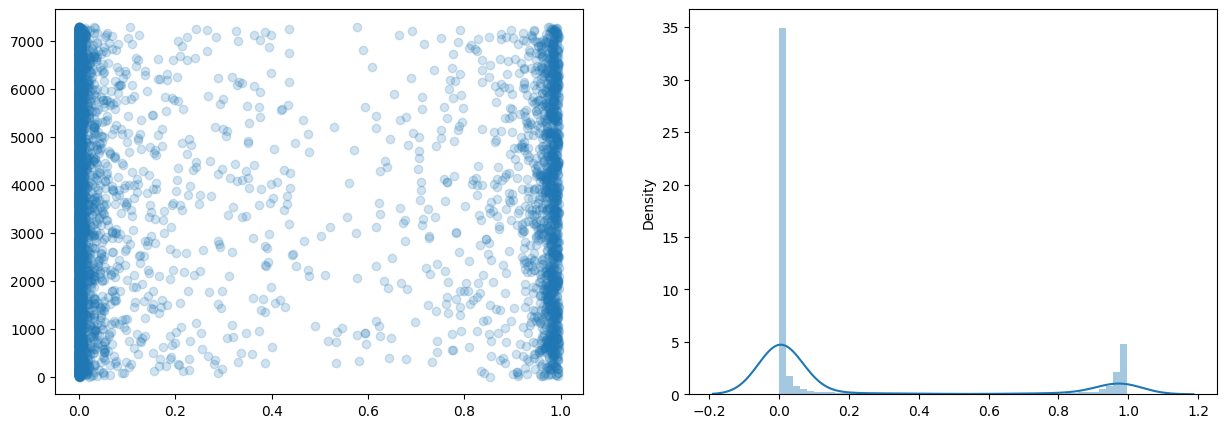

In [21]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

#### A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

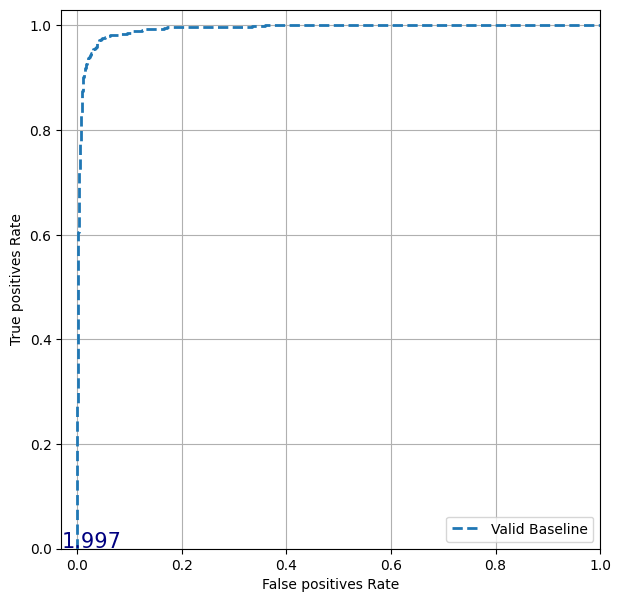

In [22]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [23]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6000
           1       0.91      0.90      0.91      1290

    accuracy                           0.97      7290
   macro avg       0.95      0.94      0.94      7290
weighted avg       0.97      0.97      0.97      7290



## TESTING MODEL ON THE TEST DATASET PROVIDED

In [24]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[ 849,  103,   27, ...,    0,    0,    0],
       [  20, 4478,  235, ...,    0,    0,    0],
       [   1,    1,    5, ...,    0,    0,    0],
       ...,
       [ 105,  227,    8, ...,    0,    0,    0],
       [2246, 1350,  107, ...,    0,    0,    0],
       [   2,    2,    2, ...,    0,    0,    0]])

array([[12692,     1,  7639, ...,     0,     0,     0],
       [    2,    60,  6492, ...,     0,     0,     0],
       [  546,   844,   690, ...,     0,     0,     0],
       ...,
       [    9,    34,   326, ...,     0,     0,     0],
       [  322,   814,   135, ...,     0,     0,     0],
       [  259,  1013,  4973, ...,     0,     0,     0]])

In [25]:
#predict on actual test data
predictions = model.predict(f_test)

538/538 [==============================] - 6s 12ms/step


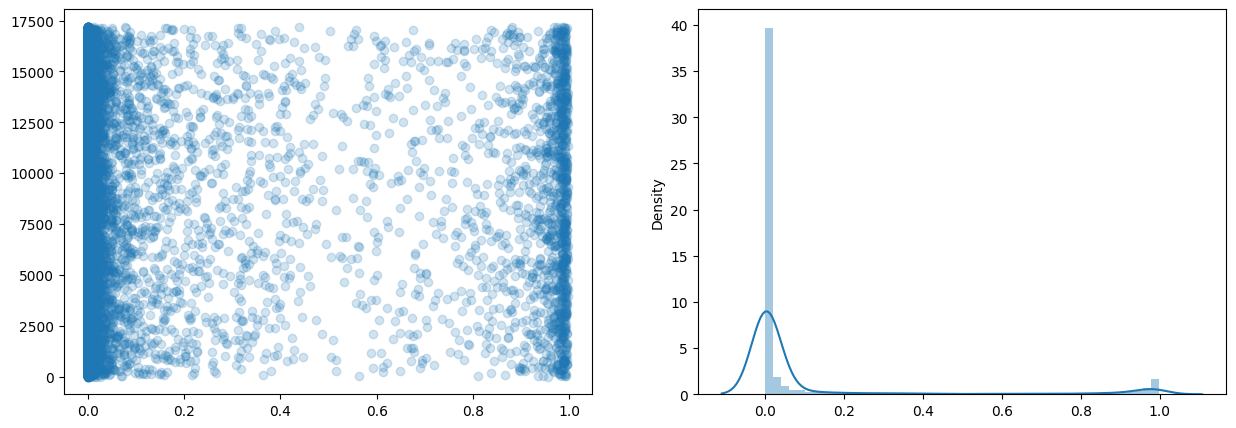

In [26]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [27]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
1,user white supremacists want everyone birdsâ movie hereâs,1.0
19,thought factory neutrality right wing fascism politics media brexit trump leadership,1.0
26,chick gets fucked hottest naked lady,1.0
30,never again thick women blacktina,1.0
33,suppo taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
...,...,...
17176,user user most racist ever,1.0
17181,user hell yeah what great surprise your present enjoy this picture bihday,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0
17192,thought factory leftright polarisation trump uselections2016 leadership politics brexit,1.0


In [28]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
19,31982,thought factory: bbc neutrality on right wing fascism #politics #media #blm #brexit #trump #leadership &gt;3
26,31989,chick gets fucked hottest naked lady
30,31993,i'll #never be #120 #again i'm #i'm a #thick #women #blacktina
33,31996,suppo the #taiji fisherman! no bullying! no racism! #tweet4taiji #thecove #seashepherd
...,...,...
17176,49139,@user @user are the most racist pay ever!!!!!
17181,49144,@user hell yeah what a great surprise for your present enjoy this picture of me #bihday
17188,49151,"black professor demonizes, proposes nazi style confiscation of ""white"" assets; like 1930's germany #breaking"
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
